In [2]:
# using libraries
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()
using Lux
using ComponentArrays
using LineSearches
using LuxAMDGPU
using LuxCUDA
using OrdinaryDiffEq
using Optimization
using OptimizationOptimJL
using Printf
using Random 
using SciMLSensitivity
using Plots

CUDA.allowscalar(false)

  Activating project at `~/Desktop/iGW_BBH-main/Extreme_Mass_Ratio`


In [3]:
# necessary julia files
include("models.jl")
include("utils.jl")

compute_waveform (generic function with 2 methods)

In [4]:
# parameters of the model extreme mass ratio
mass_ratio = 0.0         
u0 = Float64[π, 0.0]     #χ,ϕ
datasize = 250           
tspan = (0.0f0, 6.0f4)   
tsteps = range(tspan[1], tspan[2]; length=datasize)  
dt_data = tsteps[2] - tsteps[1]
dt = 100.0
const ode_model_params = [100.0, 1.0, 0.5]; # p, M, e

# Newtonian model

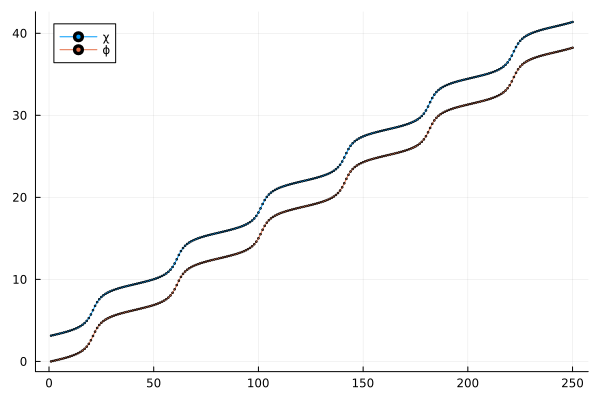

In [5]:
# solving the newtonian model
prob = ODEProblem(NewtonianOrbitModel, u0, tspan, ode_model_params)
soln = Array(solve(prob, RK4(); saveat=tsteps, dt, adaptive=false))

# plotting the solution
Plots.plot(soln[:1,:], linewidth = 1, marker=:circle, markersize = 1, label = "χ")
Plots.plot!(soln[:2,:],linewidth = 1, marker=:circle, markersize = 1, label= "ϕ")

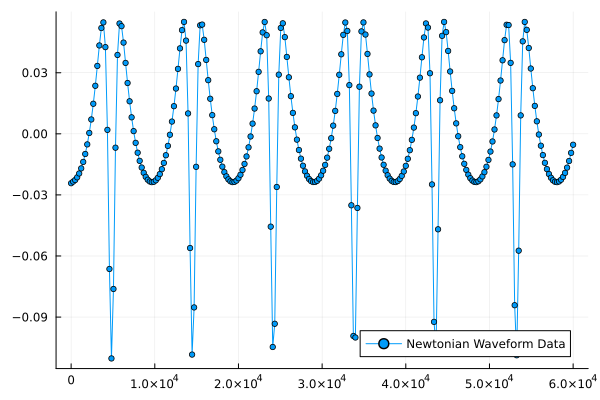

In [6]:
# computing the waveform
waveform = first(compute_waveform(dt_data, soln, mass_ratio, ode_model_params))

# ploting using Plots.plot
Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 3, label = "Newtonian Waveform Data")

# Relativistic model

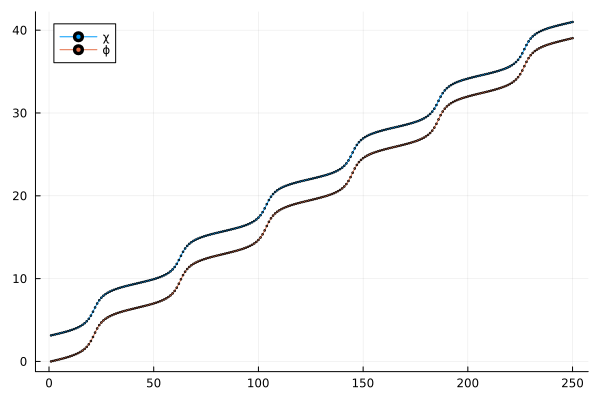

In [7]:
# solving the relativistic model
prob = ODEProblem(RelativisticOrbitModel, u0, tspan, ode_model_params)
soln = Array(solve(prob, RK4(); saveat=tsteps, dt, adaptive=false))
waveform = first(compute_waveform(dt_data, soln, mass_ratio, ode_model_params))

# plotting the solution
Plots.plot(soln[:1,:], linewidth = 1, marker=:circle, markersize = 1, label = "χ")
Plots.plot!(soln[:2,:],linewidth = 1, marker=:circle, markersize = 1, label= "ϕ")

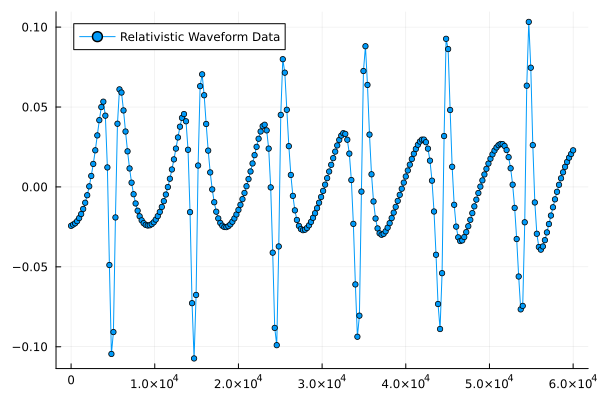

In [8]:
# computing the waveform
waveform = first(compute_waveform(dt_data, soln, mass_ratio, ode_model_params))

# ploting using Plots.plot
Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 3, label = "Relativistic Waveform Data")

# Neural Network model

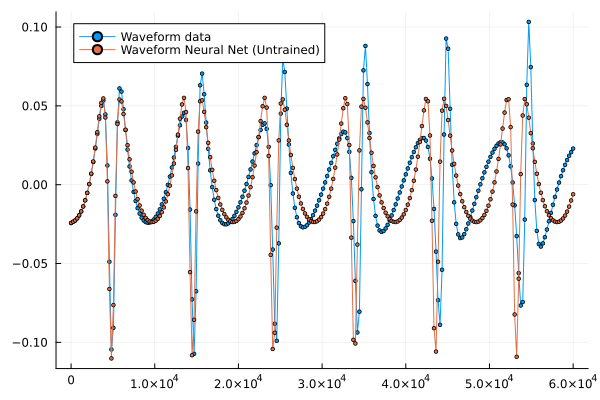

In [9]:
# definition of the neural network
nn = Chain(Base.Fix1(broadcast, cos),
    Dense(1 => 32, cos; init_weight=truncated_normal(; std=1e-4)),
    Dense(32 => 32, cos; init_weight=truncated_normal(; std=1e-4)),
    Dense(32 => 2; init_weight=truncated_normal(; std=1e-4)))
#  setup a specific random number generator (RNG) from the Xoshiro generator
ps, st = Lux.setup(Xoshiro(), nn)

params = ComponentArray{Float64}(ps)
nn_model = StatefulLuxLayer(nn, st)

# solving using neural networks without train
prob_nn = ODEProblem(ODE_model, u0, tspan, params)
soln_nn = Array(solve(prob_nn, RK4(); u0, p=params, saveat=tsteps, dt, adaptive=false))
waveform_nn = first(compute_waveform(dt_data, soln_nn, mass_ratio, ode_model_params))


# ploting using Plots.plot
Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform data")
Plots.plot!(tsteps, waveform_nn, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform Neural Net (Untrained)")

In [10]:
# defining the loss function
function loss(θ)
    pred = Array(solve(prob_nn, RK4(); u0, p=θ, saveat=tsteps, dt, adaptive=false))
    pred_waveform = first(compute_waveform(dt_data, pred, mass_ratio, ode_model_params))
    loss = sum(abs2, waveform .- pred_waveform)
    return loss, pred_waveform
end

loss(params)

const losses = Float64[]

function callback(θ, l, pred_waveform)
    push!(losses, l)
    @printf "Training %10s Iteration: %5d %10s Loss: %.10f\n" "" length(losses) "" l
    return false
end

callback (generic function with 1 method)

In [11]:
# training the neural network
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, params)
res = Optimization.solve(optprob, BFGS(; initial_stepnorm=0.01, linesearch=LineSearches.BackTracking());callback, maxiters=1000)

Training            Iteration:     1            Loss: 0.1775970048
Training            Iteration:     2            Loss: 0.0679151668
Training            Iteration:     3            Loss: 0.0370973726
Training            Iteration:     4            Loss: 0.0091619003
Training            Iteration:     5            Loss: 0.0002694141
Training            Iteration:     6            Loss: 0.0002071618
Training            Iteration:     7            Loss: 0.0002046866
Training            Iteration:     8            Loss: 0.0002046730
Training            Iteration:     9            Loss: 0.0002046729
Training            Iteration:    10            Loss: 0.0002046729
Training            Iteration:    11            Loss: 0.0002046729
Training            Iteration:    12            Loss: 0.0002046729
Training            Iteration:    13            Loss: 0.0002046729
Training            Iteration:    14            Loss: 0.0002046729
Training            Iteration:    15            Loss: 0.000204

retcode: Success
u: ComponentVector{Float64}(layer_1 = Float64[], layer_2 = (weight = [-9.810111805578142e-5; 0.00014575375826093132; … ; 0.00014054702478453023; 5.643103941107529e-5;;], bias = [1.6367454624071252e-16; 5.6824590195705e-17; … ; 8.937159436603299e-17; 3.796939480525347e-17;;]), layer_3 = (weight = [-0.00010423470988586719 -0.00013689915389238763 … 0.00011503533138477421 1.0607699062015948e-5; -7.42884728385254e-5 5.811708255633564e-6 … -0.0001302735469795952 -6.573941181675338e-5; … ; -0.00012485499893118975 0.00010861117779239372 … 0.0001591880399147932 -9.488700298861267e-5; -5.806938034765963e-5 4.971238036051473e-7 … 2.0285985638117557e-5 -8.195957244425043e-5], bias = [1.7575645298254763e-9; 2.1248564072645e-9; … ; 3.24224784708405e-9; -1.672478906303457e-9;;]), layer_4 = (weight = [-0.0006546062596660464 -0.0008226201195581382 … -0.0006373340881347043 -0.0006315059951887709; 0.00025555109054623904 0.00016690733238942468 … 0.0001711829333538362 0.0003671361417781767

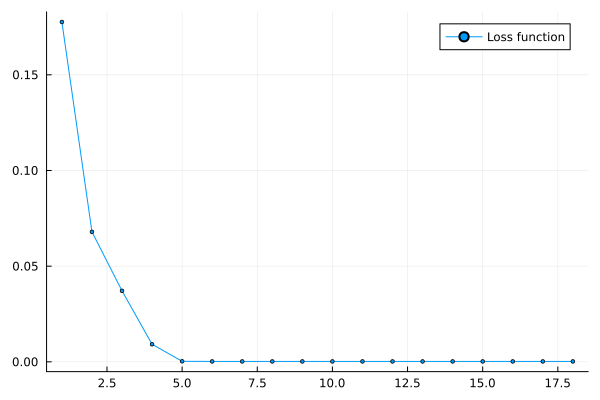

In [16]:
# ploting the loss function using Plots.plot
Plots.plot(1:length(losses), losses, linewidth = 1, marker=:circle, markersize = 2, label = "Loss function")

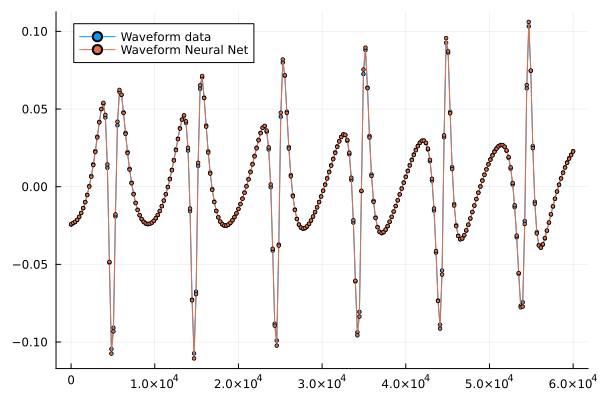

In [17]:
# ploting the data waveform and the neural network waveform
prob_nn = ODEProblem(ODE_model, u0, tspan, res.u)
soln_nn = Array(solve(prob_nn, RK4(); u0, p=res.u, saveat=tsteps, dt, adaptive=false))
waveform_nn_trained = first(compute_waveform(dt_data, soln_nn, mass_ratio, ode_model_params))

Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform data")
Plots.plot!(tsteps, waveform_nn_trained, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform Neural Net")

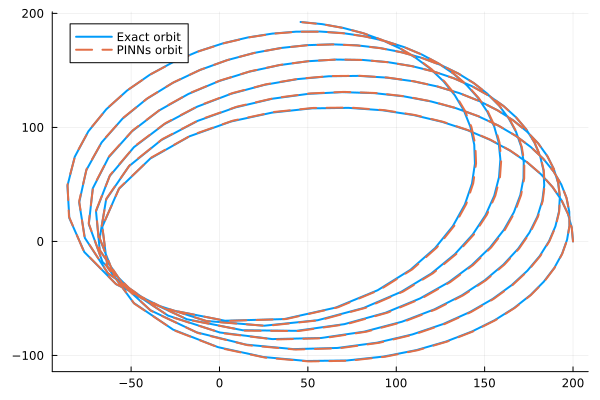

In [18]:
# ploting the orbit
reference_solution = solve(remake(prob, p = ode_model_params, saveat = tsteps, tspan=tspan),RK4(), dt = dt, adaptive=false)
optimized_solution = solve(remake(prob_nn, p = res.minimizer, saveat = tsteps, tspan=tspan),RK4(), dt = dt, adaptive=false)

true_orbit = soln2orbit(reference_solution, ode_model_params)
pred_orbit = soln2orbit(optimized_solution, ode_model_params)

plt = Plots.plot(true_orbit[1,:], true_orbit[2,:], linewidth = 2, label = "Exact orbit")
Plots.plot!(plt, pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 2, label = "PINNs orbit")

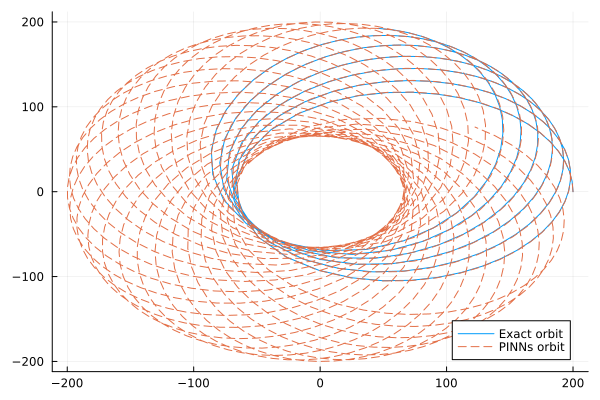

In [19]:
# ploting the entire orbit to see the constrats
factor=5
extended_tspan = (tspan[1], factor*tspan[2])
extended_tsteps = range(tspan[1], factor*tspan[2], length = factor*datasize)

reference_solution = solve(remake(prob, p = ode_model_params, saveat = tsteps, tspan = tspan),RK4(), dt = dt, adaptive=false)
optimized_solution = solve(remake(prob_nn, p = res.minimizer, saveat = extended_tsteps, tspan=extended_tspan),RK4(), dt = dt, adaptive=false)

true_orbit = soln2orbit(reference_solution, ode_model_params)
pred_orbit = soln2orbit(optimized_solution, ode_model_params)

Plots.plot(true_orbit[1,:], true_orbit[2,:], linewidth = 1, label = "Exact orbit")
Plots.plot!(pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 1, label = "PINNs orbit")